<a href="https://colab.research.google.com/github/rmogi/HousePrice/blob/branch-furusawa/furusawa/HousePrice_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip house-prices-advanced-regression-techniques

Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


今回のkaggleではアイオワ州エイムズの住宅の性質を説明する79個の説明変数がある。そのデータから各住宅の価格を予測する。



In [2]:
# 今日は何をやるか
# グラフの相関はもうちょっと見たい
# どのようなモデルが有効なのか考え適用　→ランダムフォレスト,SVR,LinearR,XGBoost(勾配ブースティングとランダムフォレストのアンサンブル),LightGBM(2択に強い),ロジスティック回帰,これらのアンサンブルをとる

# とりあえずXGBoost,Randomforest,LinearGBMで試してみる←RF終了、精度を確認したいので過学習が起きていないか、トレーニングデータで精度を確かめたい。
# でもtestの正解ラベルがないのにどうやって精度を確かめればいいのだろう。トレーニングデータを学習させているから、...！
# トレーニングデータで交差検証すればいいんだ！そうすればモデル自体の精度(今回のデータにこのモデルが適しているか)を確認できるはずだ。←今ここ

# LightGBMやXGBoostの検証はカテゴリ変数の処理と交差検証が導入できたら雛形をコピーして検証する

# 欠損値を埋めることで重要な特徴量の変化はあるか？→延期、多いものは削除、少ないものは中央値埋めの方向で
# カテゴリ変数の処理(le?ダミー変数？)→とりあえずすべてleで変換しといた。

# 今日の予定ではないが、データの学習方法に工夫は出来ないか？
# ハイパーパラメータのOptunaってどうやって使うんだっけ？今回は使えない？
# それともグリッドサーチ？

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
all = pd.concat([train, test], sort = False)
print(train.shape)
print(test.shape)
print(all.shape)
print(all.info())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(1460, 81)
(1459, 80)
(2919, 81)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919

カラムメモ

データフィールド
以下は、データ記述ファイルにあるものの簡単なバージョンです。


SalePrice-プロパティ(土地、住宅)のドルでの販売価格。これは、予測しようとしているターゲット変数です。

MSSubClass：建物クラス

MSZoning：一般的なゾーニング分類

LotFrontage：プロパティ(土地、住宅)に接続された道路の線形フィート

LotArea：平方フィート単位のロットサイズ(土地の大きさ)

Street(ストリート)：道路アクセスのタイプ

Alley(路地)：路地アクセスのタイプ

LotShape：プロパティ(土地、住宅)の一般的な形状

LandContour：プロパティ(土地、住宅)の平坦性

Utilities(ユーティリティ)：利用可能なユーティリティのタイプ(効用・有用)

LotConfig：ロット構成

LandSlope：プロパティ(土地、住宅)の勾配

Neighborhood(近所)：エームズ市の制限内の物理的な場所

Condition1(条件1)：幹線道路または鉄道に近接

Condition2(条件2)：幹線道路または鉄道に近接している（秒がある場合）

BldgType：住居のタイプ

HouseStyle：住居のスタイル

OverallQual：全体的な材料と仕上げの品質

OverallCond：全体的な状態の評価

YearBuilt：元の建設日

YearRemodAdd：改造日

RoofStyle：屋根のタイプ

RoofMatl：屋根のマテリアル

Exterior1st：家の外装カバー

Exterior2nd：家の外装（複数の材料の場合）

MasVnrType：石積みのベニヤのタイプ

MasVnrArea：平方フィートの石積みベニア面積

ExterQual：外装材の品質

ExterCond：外装材の現状

Foundation(財団)：財団の種類

BsmtQual：地下室の高さ

BsmtCond：地下室の一般的な状態

BsmtExposure：ストライキまたは庭園レベルの地下壁

BsmtFinType1：地下の仕上がり面積

BsmtFinSF1：タイプ1の完成した平方フィート

BsmtFinType2：2番目に終了した領域の品質（存在する場合）

BsmtFinSF2：タイプ2仕上げ済み平方フィート

BsmtUnfSF：地下室の未完成の平方フィート

TotalBsmtSF：地下面積の合計平方フィート

Heating(暖房)：暖房の種類

HeatingQC：暖房の品質と状態

CentralAir：セントラルエアコン

Electrical(電気)：電気システム

1stFlrSF：1階の平方フィート

2ndFlrSF：2階の平方フィート

LowQualFinSF：低品質の完成した平方フィート（すべてのフロア）

GrLivArea：グレード（地上）のリビングエリアの平方フィート

BsmtFullBath：地下のフルバスルーム

BsmtHalfBath：地下半分のバスルーム

FullBath：グレードを超えるフルバスルーム(風呂)

HalfBath(ハーフバス)：グレードを超えるハーフバス

Bedroom(ベッドルーム)：地下階の上のベッドルームの数

Kitchen(キッチン)：キッチンの数

KitchenQual：キッチンの品質

TotRmsAbvGrd：グレードを超える部屋の合計（バスルームは含まれません）

Functional(機能的)：ホーム機能の評価

Fireplaces(暖炉)：暖炉の数

FireplaceQu：暖炉の品質

GarageType：ガレージの場所

GarageYrBlt：ガレージが建てられた年

GarageFinish：ガレージの内部仕上げ

GarageCars：車の容量でのガレージのサイズ

GarageArea：平方フィートで表したガレージのサイズ

GarageQual：ガレージの品質

GarageCond：ガレージの状態

PavedDrive：舗装された私道

WoodDeckSF：ウッドデッキの面積（平方フィート）

OpenPorchSF：平方フィートのオープンポーチエリア

EnclosedPorch：平方フィートで囲まれたポーチエリア

3SsnPorch：平方フィートのスリーシーズンポーチエリア

ScreenPorch：平方フィートのスクリーンポーチエリア

PoolArea：平方フィートのプール面積

PoolQC：プールの品質

Fence(フェンス)：フェンスの品質

MiscFeature：その他の機能は他のカテゴリではカバーされていません

MiscVal：その他の機能の$ Value

MoSold：販売月

YrSold：販売年

SaleType：販売のタイプ

SaleCondition：販売の条件

In [4]:
train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,...,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,...,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,...,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,

In [5]:
# 欠損値の確認
train_nan = train.isnull().sum()
train_nan = train_nan[train_nan > 0]
train_nan

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [6]:
# 欠損値の確認
test_nan = test.isnull().sum()
test_nan = test_nan[test_nan > 0]
test_nan

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

In [8]:
# 質的変数をLabelEncoderでカテゴリ化する
# Label Encodeする前の、SaleConditionカラムにセットされている値の一覧
train["SaleCondition"].unique()

array(['Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family'],
      dtype=object)

In [9]:
train.shape[1]

81

In [7]:
train.iloc[:,1].values

array([60, 20, 60, ..., 70, 20, 20])

In [10]:
# 文字列をラベル化した数値に変換する為のライブラリをインポート
from sklearn.preprocessing import LabelEncoder

# この時点でカテゴリ変数を標準化する列を指定しておく
# この時点のint64とfloat64をすべて指定、列名のみ取得


# データタイプがobjectの列の値をラベル化した数値に変換
for i in range(train.shape[1]):
    if train.iloc[:,i].dtypes == object:
        le = LabelEncoder()
        # iloc関数でobject列の全ての行の値をleに学習,(values:値,column:列,index:行)
        #le.fit()で変換したいデータを指定、le.transform()で数値へ変換
        le.fit(list(train.iloc[:,i].values) + list(test.iloc[:,i].values))
        train.iloc[:,i] = le.transform(list(train.iloc[:,i].values))
        test.iloc[:,i] = le.transform(list(test.iloc[:,i].values))

In [11]:
# Label Encodeされた後の、SaleConditionカラムにセットされている値の一覧
train["SaleCondition"].unique()

array([4, 0, 5, 1, 2, 3])

In [12]:
# 改めて欠損値の確認
train_nan = train.isnull().sum()
train_nan = train_nan[train_nan > 0]
train_nan

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

In [13]:
# 改めて欠損値の確認
test_nan = test.isnull().sum()
test_nan = test_nan[test_nan > 0]
test_nan

LotFrontage     227
MasVnrArea       15
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt      78
GarageCars        1
GarageArea        1
dtype: int64

In [14]:
# submission用にIDを取得
train_ID = train['Id']
test_ID = test['Id']

# trainとtestの正解ラベル、IDを削除
y_train = train['SalePrice']
x_train = train.drop(['Id','SalePrice'], axis=1)
x_test = test.drop('Id', axis=1)

# 欠損値処理
x_all = pd.concat([x_train, x_test])
# 欠損値の多いカラムを削除
x_all = x_all.drop(['LotFrontage','MasVnrArea','GarageYrBlt'], axis=1)
# 欠損値の少ないカラムのNaNは中央値(median)で埋める
x_all = x_all.fillna(x_all.median())

# 欠損値があるか確認→なし、OK
x_all_nan = x_all.isnull().sum()
x_all_nan = x_all_nan[x_all_nan > 0]
x_all_nan

Series([], dtype: int64)

In [15]:
# 新しい列の作成:とりあえず1階2階地下の面積を足した列を作成
x_all["TotalSF"] = x_all["TotalBsmtSF"] + x_all["1stFlrSF"] + x_all["2ndFlrSF"]

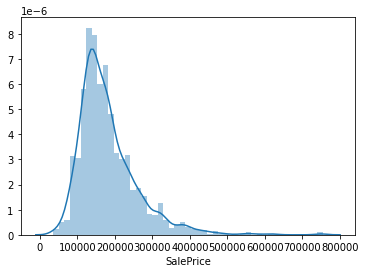

In [16]:
# SalePriceが正規分布に従っているか
sns.distplot(y_train)
plt.show()

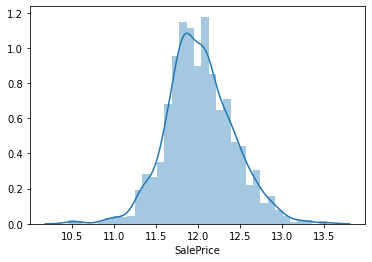

In [17]:
# 対数変換を実施
# 数字のばらつき、偏りを小さくする
y_train = np.log(y_train)

sns.distplot(y_train)
plt.show()

Training done using Random Forest


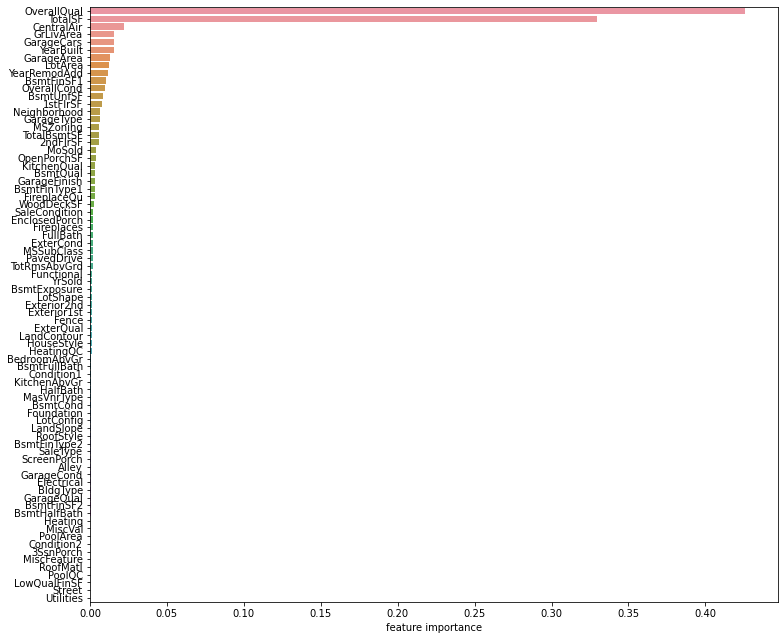

In [19]:
# randomforestregressorで重要な特徴量を上から順に表示

# trainデータとtestデータを含んでいるXmatを、再度trainデータとtestデータに分割
x_train = x_all.iloc[:train.shape[0],:]
x_test = x_all.iloc[train.shape[0]:,:]

# ランダムフォレストをインポート
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=80, max_features='auto')
rf.fit(x_train, y_train)
print("Training done using Random Forest")

# np.argsort()はソート結果の配列のインデックスを返す。引数の頭に"-"をつけると降順。
# つまり"-rf.feature_importances_"を引数にする事で重要度の高い順にソートした配列のインデックスを返す。
ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(x=rf.feature_importances_[ranking], y=x_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

In [ ]:
# OverallQualとTotalSFの重要度が突出して高いことが判明。
# 用意されたデータの中でSalesPriceの予測に必要なfeatureは、少ししかない事が判明。
# とりあえずは上位30個のFeatureを取ってきて、それをモデルに与え、訓練を実施。
# 上位2個のFeatureを掛け合わせたものを、'Interaction'として新しいFeatureを作成。

In [ ]:
# 上位30のみ特徴量を使用
x_train = x_train.iloc[:,ranking[:30]]
x_test = x_test.iloc[:,ranking[:30]]

# 上位2つの特徴量の相互作用列を作成
x_train["Interaction"] = x_train["TotalSF"] * x_train["OverallQual"]
x_test["Interaction"] = x_test["TotalSF"] * x_test["OverallQual"]

In [20]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   int64  
 2   LotArea        1460 non-null   int64  
 3   Street         1460 non-null   int64  
 4   Alley          1460 non-null   int64  
 5   LotShape       1460 non-null   int64  
 6   LandContour    1460 non-null   int64  
 7   Utilities      1460 non-null   int64  
 8   LotConfig      1460 non-null   int64  
 9   LandSlope      1460 non-null   int64  
 10  Neighborhood   1460 non-null   int64  
 11  Condition1     1460 non-null   int64  
 12  Condition2     1460 non-null   int64  
 13  BldgType       1460 non-null   int64  
 14  HouseStyle     1460 non-null   int64  
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [ ]:
# 標準化で値を整える
# z-scoreにて標準化
# (値 - 平均) / 標準偏差
# x_train = (x_train - x_train.mean()) / x_train.std()
# x_test = (x_test - x_test.mean()) / x_test.std()

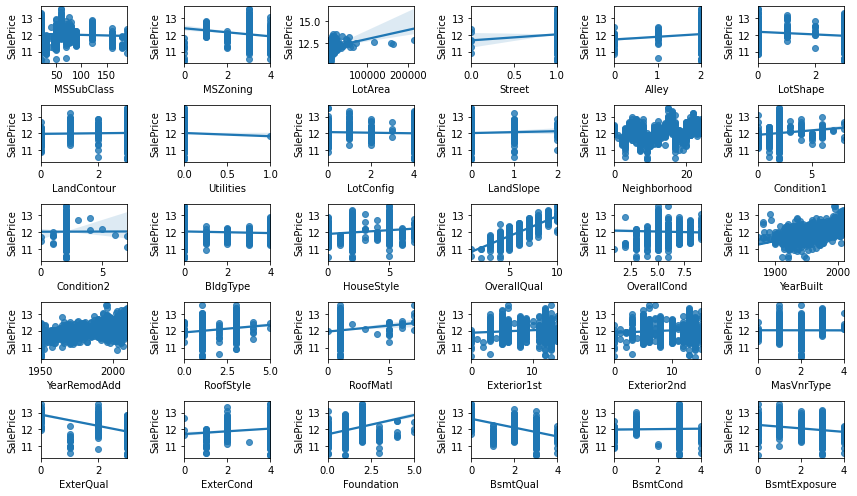

In [22]:
# 目的変数と説明変数の関係を図示
fig = plt.figure(figsize=(12,7))
for i in np.arange(30):
    ax = fig.add_subplot(5,6,i+1)
    sns.regplot(x=x_train.iloc[:,i], y=y_train)

plt.tight_layout()
plt.show()

In [23]:
# 外れ値の削除
x_all= x_train
x_all['SalePrice'] = y_train
x_all = x_all.drop(index = x_all[(x_all['TotalSF'] > 5) & (x_all['SalePrice'] < 12.5)].index)
x_all = x_all.drop(index = x_all[(x_all['GrLivArea'] > 5) & (x_all['SalePrice'] < 13)].index)

# recover
y_train = x_all['SalePrice']
x_train = x_all.drop(['SalePrice'], axis=1)

In [28]:
# モデルの作成
# アルゴリズムにランダムフォレストを採用
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#モデルのパイプラインを構築
random_forest = Pipeline([
                ("scaler", StandardScaler()),
                ("tree", RandomForestRegressor(n_estimators=1000)) #max_depthの制限をなくすと精度は上がる
])
random_forest.fit(x_train, y_train)

# 学習済みのモデルから予測した結果をセット
# logで小さくなった尺度をexpで戻す
pred = np.exp(random_forest.predict(x_test))
# 学習済みのモデルから予測した結果を出力
pred

array([511242.74008078, 513682.52642841, 514550.24958229, ...,
       511227.02269602, 508906.88603799, 506592.73238621])

In [30]:
# 必要なライブラリの import
from sklearn.model_selection import train_test_split

# データの分割
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, random_state=0)

#モデルのパイプラインを構築
random_forest = Pipeline([
                ("scaler", StandardScaler()),
                ("tree", RandomForestRegressor(n_estimators=1000)) #max_depthの制限をなくすと精度は上がる
])
random_forest.fit(X_train, Y_train)

# test set を用いて評価
score = random_forest.score(X_test, Y_test)
print('Test set score: {}'.format(score))

Test set score: -2.372875261734548


In [31]:
from sklearn.model_selection import cross_val_score
# 交差検証
scores = cross_val_score(random_forest, x_train, y_train)
# 各分割におけるスコア
print('Cross-Validation scores: {}'.format(scores))
# スコアの平均値
print('Average score: {}'.format(np.mean(scores)))

Cross-Validation scores: [-1.57490219  0.29940474 -1.20229956 -6.39142874  0.34360934]
Average score: -1.7051232841124548


In [29]:
# submission
submission = pd.DataFrame({
    "Id": test_ID,
    "SalePrice": pred
})
submission.to_csv('submission.csv', index=False)